In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim

from PIL import Image
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 Load from Google Drive

In [3]:
import os
drive_path = "/content/drive/MyDrive/Colab Notebooks/CVIP 랩/ResNet 구현"
local_data_path = "/content/data"

if os.path.exists(f"{drive_path}/train.tar")and os.path.exists(f"{drive_path}/test.tar"):
    print("tar 파일 발견. tar 파일 로딩 시작.")

    !mkdir -p {local_data_path}

    !cp "{drive_path}/train.tar" /content/
    !cp "{drive_path}/test.tar" /content/

    print("압축 해제 중...")
    !tar -xf /content/train.tar -C {local_data_path}
    !tar -xf /content/test.tar -C {local_data_path}
else:
    print("최초 실행 : 원본 데이터(7z) 변환 작업 시작")
    !cp "{drive_path}/train.7z" /content/
    !cp "{drive_path}/test.7z" /content/

    !mkdir -p {local_data_path}
    !7z x /content/train.7z -o{local_data_path} -y > /dev/null 2>&1
    !7z x /content/test.7z -o{local_data_path} -y > /dev/null 2>&1
    print("데이터 변환 및 백업 중 ..")
    !tar -cf /content/train.tar -C {local_data_path} train
    !tar -cf /content/test.tar -C {local_data_path} test

    !mv /content/train.tar "{drive_path}/"
    !mv /content/test.tar "{drive_path}/"

tar 파일 발견. tar 파일 로딩 시작.
압축 해제 중...


In [4]:
import os

input_dir = '/content/data/test'
output_dir = '/content/data/train'

# 1. 경로가 진짜 있는지 먼저 체크
if not os.path.exists(input_dir):
    print(f"경로를 찾을 수 없습니다.: {input_dir}")

else:
    # 2. 파일 개수 확인
    input_files = [f for f in os.listdir(input_dir) if not f.startswith('.')]
    output_files = [f for f in os.listdir(output_dir) if not f.startswith('.')]

    print(f"Test 파일: {len(input_files)}개")
    print(f"Train 파일: {len(output_files)}개")

Test 파일: 300000개
Train 파일: 50000개


# Transforms

In [5]:
# Data Augmentation -> To Tensor -> Normalization
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.225, 0.224, 0.225])
])

test_transform = transforms.Compose([
    # Resize -> ToTensor -> Normalization
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.225, 0.224, 0.225])
])

# CustomDatasets

In [6]:
class_to_idx = {
    'airplane' : 0,
    'automobile' : 1,
    'bird' : 2,
    'cat' : 3,
    'deer' : 4,
    'dog' : 5,
    'frog' : 6,
    'horse' : 7,
    'ship' : 8,
    'truck' : 9
}
idx_to_class = {
    0 : 'airplane',
    1 : 'automobile',
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck'
}

In [7]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.label_df = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.label_df)

    def __getitem__(self, idx):
        img_id = self.label_df.iloc[idx, 0]
        label_str = self.label_df.iloc[idx, 1]
        label = class_to_idx[label_str]
        img_path = os.path.join(self.img_dir, f"{img_id}.png")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.image_dir = img_dir
        self.transform = transform
        self.image_ids = sorted([(f.replace('.png', '')) for f in os.listdir(img_dir) if f.endswith('.png')])

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f"{img_id}.png")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_id

# DataLoader

In [8]:
train_dataset = CustomDataset(img_dir = '/content/data/train', csv_file = '/content/drive/MyDrive/Colab Notebooks/CVIP 랩/ResNet 구현/trainLabels.csv', transform=train_transform)
test_dataset = TestDataset(img_dir = '/content/data/test', transform=test_transform)

In [9]:
from torch.utils.data import random_split

train_size = int(0.8*len(train_dataset))
print("= = train size = = ")
print(train_size)

print("= = len(train_dataset) = =")
print(len(train_dataset))

val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, (train_size, val_size))

= = train size = = 
40000
= = len(train_dataset) = =
50000


In [10]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Modeling Nueral Net

In [11]:
!pip install torchinfo

In [12]:
import torchvision.models as models
model = models.resnet18(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s]


In [13]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728

In [14]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
image_tensor, label_idx = next(iter(train_loader))
print(image_tensor.shape)

torch.Size([32, 3, 224, 224])


In [22]:
image_np = image_tensor[0].permute(1, 2, 0).numpy()
image_np = image_np * [0.225, 0.224, 0.225] + [0.485, 0.456, 0.406]
height, width, channels = image_np.shape
print(f"Image Width: {width} pixels")
print(f"Image Height: {height} pixels")

Image Width: 224 pixels
Image Height: 224 pixels


In [23]:
# 모델 클래스 정의 후 아래 코드를 꼭 실행해보세요.

def test_model():
    # 1. 임의의 텐서 생성 (Batch=2, Channel=3, Height=224, Width=224)
    dummy_input = torch.randn(2, 3, 224, 224)

    # 2. 통과 시켜보기 (여기서 에러 나면 아키텍처 설계 미스)
    try:
        output = model(dummy_input)
        print("Output Size:", output.shape)
        # 예상: [2, 1000] -> 성공!
    except Exception as e:
        print("에러 발생! 셰이프 계산 다시 하세요:", e)

test_model()

Output Size: torch.Size([2, 1000])


# Loss Function & Optimizer

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train and Evaluate

In [26]:
def train(model, train_loader, criterion, optimizer, epoch):
    model.train()

    running_loss=0.0
    correct=0
    total=0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch {epoch} : 평균 Loss = {running_loss / len(train_loader)}")
    return epoch_loss

In [27]:
def val(model, val_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy : .2f}%")
    return accuracy

In [29]:
num_epochs = 20
best_acc = 0.0
best_model_weights = None

train_loss =[]
val_accuracy = [] # Fix: Changed 'val_accuarcy' to 'val_accuracy'

for epoch in range(1, num_epochs+1):
    train_loss.append(train(model, train_loader, criterion, optimizer, epoch))

    val_acc = val(model, val_loader, criterion)
    val_accuracy.append(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_weights = model.state_dict()

model.load_state_dict(best_model_weights)

Epoch 1 : 평균 Loss = 0.6286560473322869
Validation Accuracy:  82.35%
Epoch 2 : 평균 Loss = 0.45238643495440484
Validation Accuracy:  86.33%
Epoch 3 : 평균 Loss = 0.368002393206954
Validation Accuracy:  88.01%
Epoch 4 : 평균 Loss = 0.3185770395770669
Validation Accuracy:  88.70%
Epoch 5 : 평균 Loss = 0.2786656160742044
Validation Accuracy:  90.24%
Epoch 6 : 평균 Loss = 0.24730464505255223
Validation Accuracy:  89.03%
Epoch 7 : 평균 Loss = 0.2222361483462155
Validation Accuracy:  89.94%
Epoch 8 : 평균 Loss = 0.2025377474412322
Validation Accuracy:  89.27%
Epoch 9 : 평균 Loss = 0.1813430343773216
Validation Accuracy:  89.86%
Epoch 10 : 평균 Loss = 0.1693069093009457
Validation Accuracy:  89.54%
Epoch 11 : 평균 Loss = 0.157671950853616
Validation Accuracy:  90.87%
Epoch 12 : 평균 Loss = 0.14184994992800057
Validation Accuracy:  90.73%
Epoch 13 : 평균 Loss = 0.1319810363382101
Validation Accuracy:  90.60%
Epoch 14 : 평균 Loss = 0.1275819842018187
Validation Accuracy:  91.03%
Epoch 15 : 평균 Loss = 0.117715914661251
Val

<All keys matched successfully>

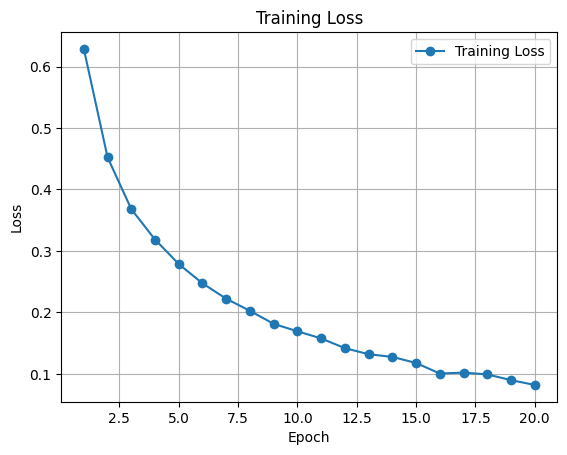

In [30]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(1, num_epochs + 1), train_loss, label="Training Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()
plt.show()

In [33]:
def test(model, test_loader):
    model.eval()

    all_ids=[]
    all_preds=[]

    with torch.no_grad():
        for images, img_ids in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs.data, 1)

            all_ids.extend(img_ids)
            all_preds.extend(preds.cpu().numpy())

    return all_ids, all_preds

In [34]:
all_ids, all_preds = test(model, test_loader)

In [36]:
pred_labels = [idx_to_class[pred] for pred in all_preds]
submission = pd.DataFrame({
    "id" : all_ids,
    "label" : pred_labels
})

submission = submission.sort_values('id')
submission.to_csv("submission.csv", index=False)